/var/folders/fn/p3bkwtks4sx_zsgkbpn8jqvr0000gn/T/ipykernel_61457/1247519819.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


auth success 
Query data....
Calculate...


/var/folders/fn/p3bkwtks4sx_zsgkbpn8jqvr0000gn/T/ipykernel_61457/1247519819.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: x.rank(pct=True)[-1], raw=False)


Success...


/var/folders/fn/p3bkwtks4sx_zsgkbpn8jqvr0000gn/T/ipykernel_61457/1247519819.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: x.rank(pct=True)[-1], raw=False)
/var/folders/fn/p3bkwtks4sx_zsgkbpn8jqvr0000gn/T/ipykernel_61457/1247519819.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annual_ret = pow(strategy_cum[-1] / strategy_cum[0],
/var/folders/fn/p3bkwtks4sx_zsgkbpn8jqvr0000gn/T/ipykernel_61457/1247519819.py:490: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

,钝化RSRS,右偏修正标准分RSRS
年华收益率,-8.73%,-11.17%
累计收益率,-8.14%,-10.43%
夏普比率,-4.048108,-3.717078
最大回撤,9.04%,13.59%
持仓总天数,47,75
交易次数,1,1
平均持仓天数,47.0,75.0
获利天数,16,29
亏损天数,31,46
胜率(按天),34.04%,38.67%


/opt/anaconda3/envs/big_brother/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 27818 (\N{CJK UNIFIED IDEOGRAPH-6CAA}) missing from current font.
  func(*args, **kwargs)
/opt/anaconda3/envs/big_brother/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 28145 (\N{CJK UNIFIED IDEOGRAPH-6DF1}) missing from current font.
  func(*args, **kwargs)
/opt/anaconda3/envs/big_brother/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from current font.
  func(*args, **kwargs)
/opt/anaconda3/envs/big_brother/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  func(*args, **kwargs)
/opt/anaconda3/envs/big_brother/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 34920 (\N{CJK UNIFIED IDEOGRAPH-8868}) missing from current font.
  func(*args, **kwargs)
/opt/anaconda3/

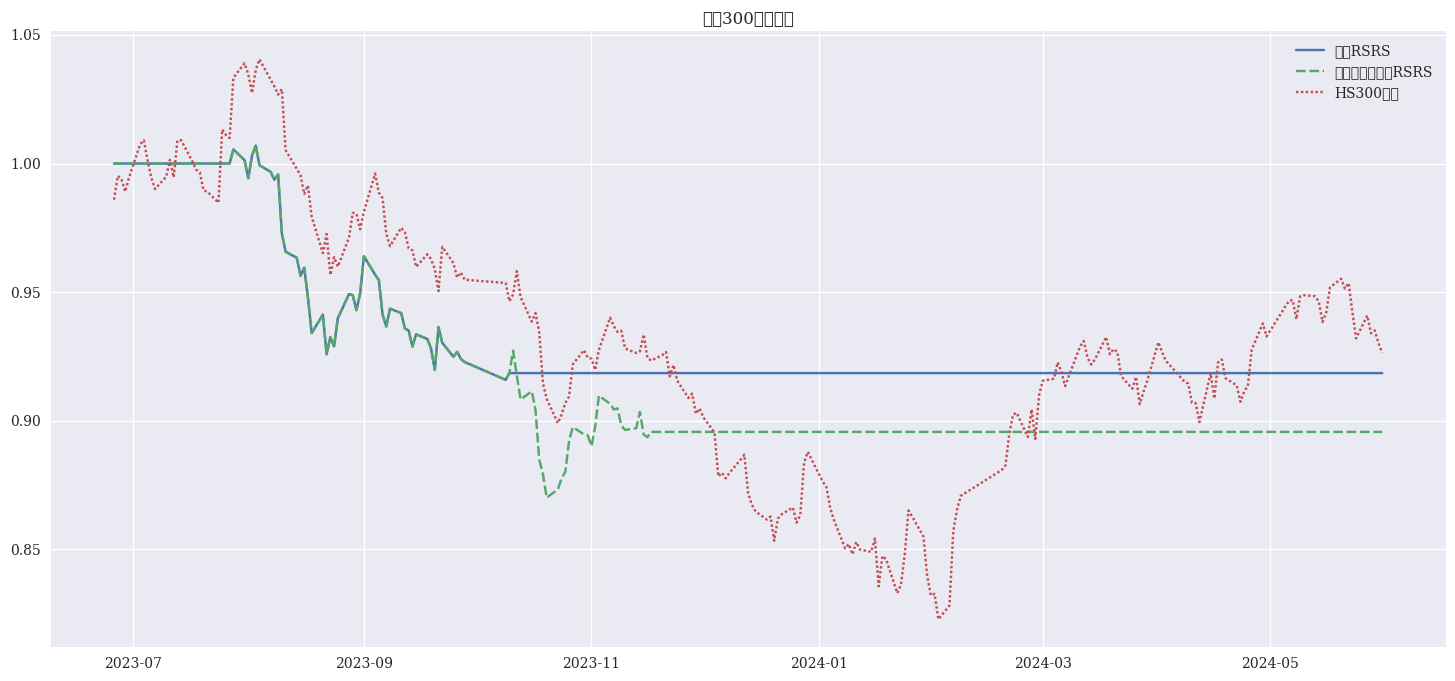

In [1]:
# 引入库
from jqdatasdk import *

# 标记交易时点
import pandas as pd
import numpy as np
import scipy.stats as st  # 统计库
import statsmodels.api as sm  # 线性回归

# from IPython display
from IPython.core.display import HTML, display
import itertools  # 迭代器工具

from dateutil.parser import parse
import datetime as dt

# 画图
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns

# 设置字体 用来正常显示中文标签
mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.sans-serif'] = ['SimHei']

# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
# print(plt.style.available)
# sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')
auth('17600228567','Gao19930923')
'''
属性中的data用于储存原始数据
_Cal_RSRS处理data _Cal_RSRS生成信号列表

'''


class RSRS(object):

    def __init__(self):

        self.symbol = ''
        self.start_date = ''
        self.end_date = ''
        self.N = ''
        self.M = ''
        self.threshold = {}
        self.freq = {}

        self.price_df = pd.DataFrame()
        self.singal_df = pd.DataFrame()
        self.position_df = pd.DataFrame()

        self.hold_mark = {}
        self.buy_mark = {}
        self.sell_mark = {}

        self.strategy_ret = pd.DataFrame()
        self.strategy_cum = pd.DataFrame()

    # ==============================================================================
    #                       回测
    # ==============================================================================

    # 初始加载
    def init_from_config(self, symbol, start_date, end_date, freq):

        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.freq = freq

        # 获取前序时间
        self._get_pretreatment_day()
        # 检查前序时间是否足够
        self._check_pretreatment_date()

        print('Query data....')
        self.query_data
        print('Calculate...')
        self.get_singal_table
        print('Success...')

    # 回测
    def backtesting(self, threshold_dict: dict):

        self.threshold = threshold_dict
        self.position_df, self.hold_mark, self.buy_mark, self.sell_mark = self._get_trade_info(
            self.threshold)

        self.get_net_value()

    # 数据获取
    @property
    def query_data(self):

        # 获取前序开始日
        begin = get_trade_days(
            end_date=self.start_date, count=(self.N + self.M))[0]

        # 获取价格数据
        price_df = get_price(
            self.symbol,
            begin,
            self.end_date,
            fields=['high', 'low', 'close', 'volume', 'pre_close'],
            panel=False)

        # 计算收益率
        price_df['ret'] = price_df['close'] / price_df['pre_close'] - 1

        self.price_df = price_df

    # 获取freq中各个指标计算的参数最大前序天数
    def _get_pretreatment_day(self):
        '''
        在提取数据时获取最大的N,M作为前序日期
        变换freq的k,v变换后k=(N,M),v为需要计算的RSRS名称
        相同(N,M)的合并了不用重复提取数据
        '''

        max_day = {}  # 最大前序期
        refreq = {}  # key-(N,M) value-rsrs_name

        # 判断freq中的k的rsrs名称是否合规
        self._check_threshold_key_name(self.freq.keys())

        for k, v in self.freq.items():

            max_day[k] = sum(v)
            # 转化k,v
            if v in refreq:
                refreq[v] = [refreq[v]] + [k]
            else:
                refreq[v] = k

        max_day_name = max(max_day, key=max_day.get)

        self.N = self.freq[max_day_name][0]
        self.M = self.freq[max_day_name][1]

        self.freq = refreq  # 重置freq

    # ==============================================================================
    #                   核心计算
    # ==============================================================================
    @property
    def get_singal_table(self):

        rsrs_singal = pd.concat([
            self.get_RSRS(RSRS_NAME, NM[0], NM[1])
            for NM, RSRS_NAME in self.freq.items()
        ], axis=1)

        self.singal_df = rsrs_singal

    # 计算rsrs
    def get_RSRS(self, rsrs_name, N, M):

        price_df = self.price_df

        BETA = [np.nan] * N  # 用于储存斜率
        Rsquared = [np.nan] * N  # 储存R方

        singal_df = pd.DataFrame(index=price_df.index)  # 信号储存

        # 计算OLS相关的数据
        params = self._regression()

        # ret_quantile
        ret_quantile = self._cal_ret_quantile()

        # 获取RSRS
        # 原始RSRS
        singal_df['RSRS'] = params[0]

        # 计算标准分
        singal_df['标准分RSRS'] = (singal_df['RSRS'] -
                                   singal_df['RSRS'].rolling(M).mean()
                                   ) / singal_df['RSRS'].rolling(M).std()

        # 计算修正标准分
        singal_df['修正标准分RSRS'] = singal_df['标准分RSRS'] * params[1]

        # 右偏标准分
        singal_df['右偏修正标准分RSRS'] = singal_df['修正标准分RSRS'] * singal_df['RSRS']

        # 钝化RSRS
        singal_df['钝化RSRS'] = singal_df['标准分RSRS'] * params[1] ** (2 *
                                                                        ret_quantile)

        # 成交量加权钝化RSRS
        ## 构建df
        passiv_df = pd.DataFrame({
            'beta': params[2],
            'rsquare': params[3]
        },
            index=price_df.index)

        ## 计算标准分
        passiv_z = (passiv_df['beta'] - passiv_df['beta'].rolling(M).mean()
                    ) / passiv_df['beta'].rolling(M).std()
        ## 计算成交量加权钝化RSRS
        singal_df['成交额加权钝化RSRS'] = passiv_z * passiv_df['rsquare'] ** (
                2 * ret_quantile)

        return singal_df.loc[self.start_date:, rsrs_name]

    # 回归
    def _regression(self) -> tuple:
        '''
        返回BETA_OLS,Rsquare_OLS,BETA_WLS,Rsquare_WLS
        '''
        N = self.N
        price_df = self.price_df

        BETA_OLS = [np.nan] * (N - 1)
        Rsquare_OLS = [np.nan] * (N - 1)

        BETA_WLS = [np.nan] * (N - 1)
        Rsquare_WLS = [np.nan] * (N - 1)

        for i in range(N, price_df.shape[0] + 1):
            vol = price_df['volume'][i - N:i]
            x = price_df['low'][i - N:i]
            y = price_df['high'][i - N:i]

            # 计算ols的所需数据
            ols_returns = self._cal_ols(x, y)

            # 计算加权回归的所需数据
            wls_returns = self._cal_wls(x, y, vol)

            BETA_OLS.append(ols_returns[0])
            Rsquare_OLS.append(ols_returns[1])

            BETA_WLS.append(wls_returns[0])
            Rsquare_WLS.append(wls_returns[1])

        return (BETA_OLS, Rsquare_OLS, BETA_WLS, Rsquare_WLS)

    # 计算ols回归的beta,r-squared
    @staticmethod
    def _cal_ols(x: pd.Series, y: pd.Series) -> tuple:

        # 过滤NAN
        x = np.nan_to_num(x)
        y = np.nan_to_num(y)

        X = sm.add_constant(x)
        # 计算beta
        BETA = np.linalg.lstsq(X, y, rcond=-1)[0][1]
        # 计算r-squared
        Rsquared = np.corrcoef(x, y)[1, 0] ** 2

        return (BETA, Rsquared)

    # 计算wls回归的beta,r-squared
    def _cal_wls(self, x: pd.Series, y: pd.Series, vol: pd.Series) -> tuple:

        # 过滤NAN
        x = np.nan_to_num(x)
        y = np.nan_to_num(y)

        X = sm.add_constant(x)
        # 计算权重
        weights = self._get_vol_weights(vol)

        results = sm.WLS(y, X, weights=weights).fit()

        # 计算beta
        BETA = results.params[1]
        # 计算r-squared
        Rsquared = results.rsquared

        return (BETA, Rsquared)

    # 计算ret分位数
    def _cal_ret_quantile(self) -> np.array:

        # 计算收益波动
        ret_std = self.price_df['ret'].rolling(self.N, min_periods=1).apply(np.nanstd, raw=False)
        ret_quantile = ret_std.rolling(self.M).apply(
            lambda x: x.rank(pct=True)[-1], raw=False)

        return ret_quantile.values

    # 计算成交量权重
    @staticmethod
    def _get_vol_weights(slice_series: pd.Series) -> list:

        weights = slice_series / slice_series.sum()

        return weights.values.tolist()

    '''
    前序时间检查
    '''

    # 检查前序时间是否足够
    def _check_pretreatment_date(self):

        traget_date = get_trade_days(end_date=parse(self.start_date).date(), count=self.M + self.N)[0]
        INDEX_START_DATE = get_security_info(self.symbol).start_date

        all_trade_days = get_all_trade_days()
        # 数据最早到2005-01-01所以不能超过这个值
        MAX_TRADE_DATE = max(INDEX_START_DATE, all_trade_days[0])
        limit_date = all_trade_days[np.argwhere(all_trade_days == MAX_TRADE_DATE) + (self.M + self.N)][0][0]

        if (traget_date - INDEX_START_DATE).days < 0:
            raise Warning('指数起始日为%s,起始日至少为%s,前序日不足,可能导致比较RSRS信号的回测起止日期不同!' %
                          (INDEX_START_DATE, limit_date))

    # 获取净值
    def get_net_value(self) -> pd.DataFrame:

        # next_ret
        pct_chg = self.price_df['ret'].shift(-1).loc[self.start_date:]

        # reshape
        ret = np.broadcast_to(
            np.expand_dims(pct_chg, axis=1), self.position_df.shape)

        strategy_ret = ret * self.position_df

        index_name = get_security_info(self.symbol).name

        # 基准收益
        strategy_ret[index_name + '净值'] = self.price_df['ret']
        strategy_cum = (1 + strategy_ret.fillna(0)).cumprod()

        self.strategy_ret = strategy_ret
        self.strategy_cum = strategy_cum

    # ==============================================================================
    #                   开仓标记
    # ==============================================================================

    # 获取持仓标记,持仓时间,交易情况
    def _get_trade_info(self, threshold_dict: dict):

        self._check_threshold_key_name(threshold_dict.keys())

        # 统一threshold
        for k, v in threshold_dict.items():

            if isinstance(v, tuple) and len(v) > 1:
                pass
            else:
                threshold_dict[k] = (v, -v)

        position_df = pd.DataFrame(index=self.singal_df.index)  # 储存持仓标记
        hold_mark = {}  # 持仓时间标记
        buy_mark = {}  # 卖出标记
        sell_mark = {}

        for singal_name, threshold in threshold_dict.items():
            flag, hold_flag, buy_flag, sell_flag = self._mark_flag(
                self.singal_df, singal_name, threshold)
            position_df[singal_name] = flag
            hold_mark[singal_name] = hold_flag
            buy_mark[singal_name] = buy_flag
            sell_mark[singal_name] = sell_flag

        return (position_df, hold_mark, buy_mark, sell_mark)

    # 标记持仓和平仓
    @staticmethod
    def _mark_flag(singal_df: pd.DataFrame, singal_name: str,
                   threshold: tuple) -> tuple:
        '''
        singal_df:信号df
        singal_name:信号名称
        treshold:开平仓阈值
        ======================
        returns:
        (开平仓标记,持仓时间,买入时间,卖出时间)
        '''

        UP = threshold[0]  # 开仓阈值
        DN = threshold[1]  # 平仓阈值
        pre_singal = singal_df[singal_name].shift(1)  # 昨日信号

        hold_flag = []  # 持仓标记
        buy_flag = []  # 买入点
        sell_flag = []  # 卖出点
        flag = []  # 持仓为1 空仓为0

        # 信号指标大于UP时开仓，小于DN时平仓
        for tradeDate, row in singal_df.iterrows():

            # ===========================
            #         持仓、平仓标记
            # ===========================

            # try用于过滤flag中没有元素的情况
            try:
                # 标记买入日期
                if row[singal_name] > UP and flag[-1] == 0:

                    flag.append(1)
                    buy_flag.append(tradeDate)
                    hold_flag.append(tradeDate)

                else:

                    if flag[-1] == 1 and row[singal_name] > DN:

                        flag.append(1)
                        hold_flag.append(tradeDate)

                    # 标记卖出日期
                    elif flag[-1] == 1 and row[singal_name] <= DN:

                        flag.append(0)
                        sell_flag.append(tradeDate)

                    else:

                        flag.append(0)

            except IndexError:
                if row[singal_name] > 0.7:
                    flag.append(1)
                else:
                    flag.append(0)

        return (flag, hold_flag, buy_flag, sell_flag)  # 返回信号的list

    # 检查回测用名称
    @staticmethod
    def _check_threshold_key_name(threshold_dict_keys: list):

        singal_name = [
            'RSRS', '标准分RSRS', '修正标准分RSRS', '右偏修正标准分RSRS', '钝化RSRS',
            '成交额加权钝化RSRS'
        ]

        for k in threshold_dict_keys:
            if k not in singal_name:
                raise Warning('回测用singal_name必须在%s中' % (','.join(singal_name)))

    # ==============================================================================
    #                   风险数据
    # ==============================================================================

    def summary(self):

        self.plot_net_value()

        display(HTML(self.report().to_html()))

    # 回测报告
    def report(self):

        return pd.concat([
            self._cal_risk_indicator(col_name)
            for col_name in self.threshold.keys()
        ],
            axis=1)

    # 获取风险指标
    def _cal_risk_indicator(self, singal_name):

        strategy_cum = self.strategy_cum[singal_name]
        strategy_ret = self.strategy_ret[singal_name]
        position_df = self.position_df[singal_name]
        hold_mark = self.hold_mark[singal_name]
        buy_mark = self.buy_mark[singal_name]
        sell_mark = self.sell_mark[singal_name]

        def format_x(x):
            return '{:.2%}'.format(x)

        summary_dic = {}

        index_name = '年华收益率,累计收益率,夏普比率,最大回撤,持仓总天数,交易次数,平均持仓天数,获利天数, \
        亏损天数,胜率(按天),平均盈利率(按天),平均亏损率(按天),平均盈亏比(按天),盈利次数,亏损次数, \
        单次最大盈利,单次最大亏损,胜率(按此),平均盈利率(按次),平均亏损率(按次),平均盈亏比(按次)'.split(',')

        # 计算年华收益率
        annual_ret = pow(strategy_cum[-1] / strategy_cum[0],
                         244 / len(strategy_cum)) - 1

        # 计算累计收益率
        cum_ret_rate = strategy_cum[-1] - 1

        # 最大回撤
        max_nv = np.maximum.accumulate(np.nan_to_num(strategy_cum))
        mdd = -np.min(strategy_cum / max_nv - 1)

        # 夏普
        sharpe_ratio = (annual_ret - 0.03) / np.nanstd(strategy_cum, ddof=1)

        # 交易次数
        trade_count = len(buy_mark)

        # 持仓总天数
        total = len(hold_mark)

        # 平均持仓天数
        mean_hold = total / trade_count

        # 获利天数
        win = np.sum(np.where(strategy_ret > 0, 1, 0))

        # 亏损天数
        lose = np.sum(np.where(strategy_ret < 0, 1, 0))

        # 胜率
        win_ratio = win / total
        # 平均盈利率（天）
        mean_win_ratio = np.sum(np.where(strategy_ret > 0, strategy_ret,
                                         0)) / win
        # 平均亏损率（天）
        mean_lose_ratio = np.sum(np.where(strategy_ret < 0, strategy_ret,
                                          0)) / lose
        # 盈亏比(天)
        win_lose = win / lose

        # 盈利次数
        temp_df = pd.DataFrame({'RETURNS': strategy_ret, 'singal': position_df})

        diff = temp_df['singal'] != temp_df['singal'].shift(1)
        temp_df['singal_MARK'] = diff.cumsum()

        cond = (temp_df['singal'] == 1)
        # 每次开仓的收益率情况
        temp_df = temp_df[cond].groupby('singal_MARK')['RETURNS'].sum()

        # 盈利次数
        win_count = np.sum(np.where(temp_df > 0, 1, 0))
        # 亏损次数
        lose_count = np.sum(np.where(temp_df < 0, 1, 0))
        # 单次最大盈利
        max_win = np.max(temp_df)
        # 单次最大亏损
        max_lose = np.min(temp_df)
        # 胜率
        win_rat = win_count / len(temp_df)
        # 平均盈利率（次）
        mean_win = np.sum(np.where(temp_df > 0, temp_df, 0)) / len(temp_df)
        # 平均亏损率（天）
        mean_lose = np.sum(np.where(temp_df < 0, temp_df, 0)) / len(temp_df)
        # 盈亏比(次)
        mean_wine_lose = win_count / lose_count

        summary_dic[singal_name] = [
            format_x(annual_ret),
            format_x(cum_ret_rate), sharpe_ratio,
            format_x(mdd), total, trade_count, mean_hold, win, lose,
            format_x(win_ratio),
            format_x(mean_win_ratio),
            format_x(mean_lose_ratio), win_lose, win_count, lose_count,
            format_x(max_win),
            format_x(max_lose),
            format_x(win_rat),
            format_x(mean_win),
            format_x(mean_lose), mean_wine_lose
        ]

        summary_df = pd.DataFrame(summary_dic, index=index_name)

        return summary_df

    # 画图
    def plot_net_value(self):

        mpl.rcParams['font.family'] = 'serif'
        plt.figure(figsize=(18, 8))
        name = get_security_info(self.symbol).display_name
        plt.title(name + '净值表现')
        sns.lineplot(data=self.strategy_cum)


# 加载
hs300 = RSRS()

# 载入数据
hs300.init_from_config(
    '000300.XSHG',
    '2023-06-25',
    '2024-05-31',
    freq={
        '钝化RSRS': (18, 700),
        '右偏修正标准分RSRS': (18, 600)
    })

# 回测
hs300.backtesting({'钝化RSRS': 0.7, '右偏修正标准分RSRS': 0.7})
# 报告输出
hs300.summary()

In [4]:
#-*- codig:utf-8 -*-
import jqdatasdk as jq
from datetime import datetime, timedelta
import time
import numpy as np
import math

# https://www.joinquant.com/help/api/help#api:API%E6%96%87%E6%A1%A3
# https://www.joinquant.com/help/api/help#JQData:JQData

# aa 为你自己的帐号， bb 为你自己的密码
jq.auth('17600228567','Gao19930923')

# http://fund.eastmoney.com/ETFN_jzzzl.html
stock_pool = [
    '159915.XSHE', # 易方达创业板ETF
    '510300.XSHG', # 华泰柏瑞沪深300ETF
    '510500.XSHG', # 南方中证500ETF
]

# 动量轮动参数
stock_num = 1           # 买入评分最高的前 stock_num 只股票
momentum_day = 29       # 最新动量参考最近 momentum_day 的

ref_stock = '000300.XSHG' #用 ref_stock 做择时计算的基础数据
N = 18 # 计算最新斜率 slope，拟合度 r2 参考最近 N 天
M = 600 # 计算最新标准分 zscore，rsrs_score 参考最近 M 天
score_threshold = 0.7 # rsrs 标准分指标阈值
# ma 择时参数
mean_day = 20 # 计算结束 ma 收盘价，参考最近 mean_day
mean_diff_day = 3 # 计算初始 ma 收盘价，参考(mean_day + mean_diff_day)天前，窗口为 mean_diff_day 的一段时间


day = 1

# 财务数据查询
def get_fundamentals_info(stock):
    q = jq.query(jq.valuation.turnover_ratio,
                jq.valuation.market_cap,
                jq.indicator.eps
                ).filter(jq.valuation.code.in_([stock]))
    current_dt = time.strftime("%Y-%m-%d", time.localtime())
    current_dt = datetime.strptime(current_dt, '%Y-%m-%d')
    previous_date  = current_dt - timedelta(days = day)
    df = jq.get_fundamentals_continuously(q, end_date = previous_date, count = 5, panel = False)
    print(df)

# 根据股票名，获取股票 code
def get_stock_code(stock_name):
    securities = jq.get_all_securities()
    stock_code = securities[securities['display_name'] == stock_name].index[0]
    return stock_code

# 根据市值，获取股票池
def market_cap(): 
    wholeA = jq.get_fundamentals(jq.query(
        jq.valuation.code).filter(
            jq.valuation.market_cap > 2000
        ))
    wholeAList = list(wholeA['code'])
    return wholeAList

# 1-1 选股模块-动量因子轮动 
# 基于股票年化收益和判定系数打分,并按照分数从大到小排名
def get_rank(stock_pool):
    score_list = []
    for stock in stock_pool:
        # current_dt = time.strftime("%Y-%m-%d", time.localtime())
        # current_dt = datetime.strptime(current_dt, '%Y-%m-%d')
        current_dt = time.strftime("%Y-%m-%d", time.localtime())
        current_dt = datetime.strptime(current_dt, '%Y-%m-%d')
        previous_date  = current_dt - timedelta(days = day)
        data = jq.get_price(stock, end_date = previous_date, count = momentum_day, frequency='daily', fields=['close'])
        # 收盘价
        y = data['log'] = np.log(data.close)
        # 分析的数据个数（天）
        x = data['num'] = np.arange(data.log.size)
        # 拟合 1 次多项式
        # y = kx + b, slope 为斜率 k，intercept 为截距 b
        slope, intercept = np.polyfit(x, y, 1)
        # (e ^ slope) ^ 250 - 1
        annualized_returns = math.pow(math.exp(slope), 250) - 1
        r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
        score = annualized_returns * r_squared
        score_list.append(score)
    stock_dict = dict(zip(stock_pool, score_list))
    sort_list = sorted(stock_dict.items(), key = lambda item:item[1], reverse = True)
    print("#" * 30 + "候选" + "#" * 30)
    for stock in sort_list:
        stock_code = stock[0]
        stock_score = stock[1]
        security_info = jq.get_security_info(stock_code)
        stock_name = security_info.display_name
        print('{}({}):{}'.format(stock_name, stock_code, stock_score))
    print('#' * 64)
    code_list = []
    for i in range((len(stock_pool))):
        code_list.append(sort_list[i][0])
    rank_stock = code_list[0:stock_num]
    return rank_stock

# 2-1 择时模块-计算线性回归统计值
# 对输入的自变量每日最低价 x(series) 和因变量每日最高价 y(series) 建立 OLS 回归模型,返回元组(截距,斜率,拟合度)
# R2 统计学线性回归决定系数，也叫判定系数，拟合优度。
# R2 范围 0 ~ 1，拟合优度越大，自变量对因变量的解释程度越高，越接近 1 越好。
# 公式说明： https://blog.csdn.net/snowdroptulip/article/details/79022532
#           https://www.cnblogs.com/aviator999/p/10049646.html
def get_ols(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    r2 = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
    return (intercept, slope, r2)

# 2-2 择时模块-设定初始斜率序列
# 通过前 M 日最高最低价的线性回归计算初始的斜率,返回斜率的列表
def initial_slope_series():
    current_dt = time.strftime("%Y-%m-%d", time.localtime())
    current_dt = datetime.strptime(current_dt, '%Y-%m-%d')
    previous_date  = current_dt - timedelta(days = day)
    data = jq.get_price(ref_stock, end_date = previous_date, count = N + M, frequency='daily', fields=['high', 'low'])
    return [get_ols(data.low[i:i+N], data.high[i:i+N])[1] for i in range(M)]

# 2-3 择时模块-计算标准分
# 通过斜率列表计算并返回截至回测结束日的最新标准分
def get_zscore(slope_series):
    mean = np.mean(slope_series)
    std = np.std(slope_series)
    return (slope_series[-1] - mean) / std

# 2-4 择时模块-计算综合信号
# 1.获得 rsrs 与 MA 信号,rsrs 信号算法参考优化说明，MA 信号为一段时间两个端点的 MA 数值比较大小
# 2.信号同时为 True 时返回买入信号，同为 False 时返回卖出信号，其余情况返回持仓不变信号
# 解释：
#       MA 信号：MA 指标是英文(Moving average)的简写，叫移动平均线指标。
#       RSRS 择时信号：
#               https://www.joinquant.com/view/community/detail/32b60d05f16c7d719d7fb836687504d6?type=1
def get_timing_signal(stock):
    # 计算 MA 信号
    # current_dt = time.strftime("%Y-%m-%d", time.localtime())
    # current_dt = datetime.strptime(current_dt, '%Y-%m-%d')
    current_dt = '2023-05-27'
    current_dt = '2024-06-02'
    # 2023-05-27至2024-06-02
    previous_date  = current_dt - timedelta(days = day)    
    close_data = jq.get_price(ref_stock, end_date = previous_date, count = mean_day + mean_diff_day,  frequency = 'daily',  fields = ['close'])
    # 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1，23 天，要后 20 天
    today_MA = close_data.close[mean_diff_day:].mean() 
    # 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0，23 天，要前 20 天
    before_MA = close_data.close[:-mean_diff_day].mean()
    # 计算 rsrs 信号
    high_low_data = jq.get_price(ref_stock, end_date = previous_date, count = N,  frequency='daily',   fields = ['high', 'low'])
    intercept, slope, r2 = get_ols(high_low_data.low, high_low_data.high)
    slope_series.append(slope)

    rsrs_score = get_zscore(slope_series[-M:]) * r2
    # 综合判断所有信号
    if rsrs_score > score_threshold and today_MA > before_MA:
        return "BUY"
    elif rsrs_score < -score_threshold and today_MA < before_MA:
        return "SELL"
    else:
        return "KEEP"

slope_series = initial_slope_series()[:-1] # 除去回测第一天的 slope ，避免运行时重复加入

def get_test():
    for each_day in range(1, 100)[::-1]:
        # current_dt = time.strftime("%Y-%m-%d", time.localtime())
        # current_dt = datetime.strptime(current_dt, '%Y-%m-%d')
        current_dt = '2023-05-27'
        current_dt = '2024-06-02'
        previous_date  = current_dt - timedelta(days = each_day - 1)
        day = each_day
        print(each_day, previous_date)
        check_out_list = get_rank(stock_pool)
        for each_check_out in check_out_list:
            security_info = jq.get_security_info(each_check_out)
            stock_name = security_info.display_name
            stock_code = each_check_out
            print('今日自选股:{}({})'.format(stock_name, stock_code))
        #获取综合择时信号
        timing_signal = get_timing_signal(ref_stock)
        print('今日择时信号:{}'.format(timing_signal))
        print('*' * 100)

if __name__ == "__main__":
    check_out_list = get_rank(stock_pool)
    for each_check_out in check_out_list:
        security_info = jq.get_security_info(each_check_out)
        stock_name = security_info.display_name
        stock_code = each_check_out
        print('今日自选股:{}({})'.format(stock_name, stock_code))
    #获取综合择时信号
    timing_signal = get_timing_signal(ref_stock)
    print('今日择时信号:{}'.format(timing_signal))
    print('*' * 100)

Exception: 您的账号权限仅能获取2023-05-27至2024-06-02的数据，请调整时间参数后重试。如需更长时间的数据范围，可联系运营咨询采购